# まとめノート

今までの話をまとめる（2017/12/28）

検閲の話を適当にしているので、ちゃんとした話はsummary_note_2へ

summary_note_2の結論は検閲なくてもrobustに推定できるって言うことなので、summary_note_3で検閲をなくしてやってみる。

summary_note_3の結論は検閲なしのデータでやるとロジット予測がダメダメと言うこと。

よってデータは検閲されたデータであるという仮定をおくのが今のところは妥当。

→cutを大きくすれば、最終的なサンプルサイズは小さくなるけど、予測誤差を小さくできる。のでM市場でも動かせる。（M市場データでは十分大きな$\mu + \delta$が実現していることを仮定しないといけないが、まぁ妥当では？）

In [49]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import inv
from numpy.random import *
import numdifftools as nd
from sklearn import linear_model

## サンプルデータ

修正（2018/1/7）：データの出し方間違ってたので修正

In [98]:
a = st.uniform()
s = st.norm()
e = st.norm()
M = 5000
T = 1000
beta1 = 0.8
beta2 = -0.5
beta3 = -0.5
delta = -0.25
cut = 0.255

In [99]:
def mne(x, mu1, mu2, delta,random, a):
    prob_x = 1 + (mu2 + x[1])/delta
    prob_y = 1 + (mu1+x[0])/delta
    probs = np.cumsum([prob_x*prob_y, (1-prob_x)*prob_y, prob_x*(1-prob_y), (1-prob_x)*(1-prob_y)])
    prob = a.rvs(1, random_state = random)
    ind = np.searchsorted(probs, prob)
    if ind == 0:
        return [0,0,0]
    elif ind == 1:
        return [1,0,2]
    elif ind == 2:
        return [0,1,1]
    else:
        return [1,1,3]

# ここも企業ごとに境目帰るようにしないとダメだよ。あとrandomもね
def nash(x, mu1, mu2, true_delta, random, a):
    if x[0] < -mu1:
        if x[1] < -mu2:
            return [0,0,0]
        else :
            return [0,1,1]
    elif -mu1 < x[0] < -mu1 -true_delta:
        if x[1] < -mu2:
            return [1,0,2]
        elif -mu2 < x[1] < -mu2 -true_delta:
            return mne(x, mu1, mu2, true_delta, random, a)
        else:
            return [0,1,1]
    else:
        if x[1] < -mu2 -true_delta:
            return [1,0,2]
        else:
            return [1,1,3]
        
def diffe(p):
    p_0 = sum([True for i in data2[p, :, 2] if i == 0.0])/T
    p_2 = sum([True for i in data2[p, :, 2] if i == 3.0])/T
    return p_0 - p_2

def num(p):
    num0 = sum([True for i in data2[p, :, 2] if i == 0.0])
    num2 = sum([True for i in data2[p, :, 2] if i == 3.0])
    num1 = T - num0 - num2
    return num0, num1, num2

In [100]:
# M市場分のデータを作る。
data = e.rvs(size = (M,3), random_state = 101)
eps = s.rvs(size = (M,T,2), random_state = 18)
data2 = np.ones((M,T,3))
for m in range(M):
    for t in range(T):
        data2[m, t, :] = nash(eps[m, t, :], data[m, 0]*beta1 + data[m, 1]*beta2, data[m, 0]*beta1 + data[m, 2]*beta2, delta, m+t*M, a)

d = np.array([diffe(p) for p in range(M)])
d2 = np.reshape(np.array([num(p) for p in range(M)]), (M, 3))
df = pd.DataFrame({"Pop" : data[:,0], "Dist1" : data[:, 1], "Dist2" : data[:, 2], "diff" : d, "num0":d2[:, 0], "num1":d2[:, 1], "num2":d2[:, 2]})
df = df[(beta1 * df.Pop + beta2 * df.Dist1 + delta > cut) & (beta1 * df.Pop + beta2 * df.Dist2 + delta > cut)]
df.to_csv("robust_norm.csv")

In [101]:
df.shape

(946, 7)

## 推定

In [130]:
df = pd.read_csv("robust_norm.csv")
pop = df[["Pop"]].values[:, 0]
dist1 = df[["Dist1"]].values[:, 0]
dist2 = df[["Dist2"]].values[:, 0]
num0 = df[["num0"]].values[:, 0]
num2 = df[["num2"]].values[:, 0]
diff = df[["diff"]].values[:, 0]

In [141]:
def br(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + (T-num0-num2)*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return sum(logl)/M

def br1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + (T-num0-num2)*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return logl

def robust(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = (diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2))**2
    return -sum(r)/M

def robust1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2)
    return r

def NR(initial, fun, tol, maxit):
    theta = initial
    for i in range(0,maxit):
        G = nd.Gradient(fun)(theta)
        H = nd.Hessian(fun)(theta)
        del_theta = inv(H).dot(G)
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            print("NR終わり")
            break
    return theta

In [142]:
# 推定
tole = 0.000005
maxx = 100000
initial = [0.8,-0.5,-0.25]
result_br = NR(initial, br, tole, maxx)
result_rob = NR(initial, robust, tole, maxx)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-pac

NR終わり
NR終わり


In [143]:
# かなりいい。
result_br

array([ 0.79068607, -0.49554507, -0.2340692 ])

In [144]:
# こっちはいつも通りいい
result_rob

array([ 0.79429955, -0.49699546, -0.23984325])

## ハウスマン検定

In [145]:
def hausman(result1, result2):
    # 足したものにヘッセでもヘッセしてから足しても変わらんから別にいいのか
    H_br = nd.Hessian(br)(result1)
    inv_H_br = inv(H_br)
    tri_1 = -inv_H_br

    J_br = nd.Jacobian(br1)(result1)
    circle_1 = np.dot(J_br.T, J_br)/M

    G_rob = nd.Gradient(robust)(result2)
    a = np.matrix(-G_rob)
    tri_3 = -np.dot(inv(np.dot(a.T, a)), a.T)

    b = np.matrix(robust1(result2)).T
    circle_3 = np.dot(J_br.T, b)/M

    circle_6 = -robust(result2)

    A_11 = np.dot(np.dot(tri_1, circle_1), tri_1.T)
    A_33 = np.dot(np.dot(tri_3, circle_6), tri_3.T)
    A_13 = np.dot(np.dot(tri_1, circle_3), tri_3.T)
    A_31 = np.dot(np.dot(tri_3, circle_3.T), tri_1.T)
    
    avar = A_11 - A_13 -A_31 + A_33
    gap = np.matrix(result1 - result2)
    h = M * np.dot(np.dot(gap, inv(avar)), gap.T)
    
    return h, np.rank(avar)

In [146]:
h, rank = hausman(result_br, result_rob)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/core.py:951: RuntimeWarning: invalid value encountered in double_scalars
  f(x - ee[i, :] + ee[j, :], *args, **kwargs) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5

In [147]:
print(h)
print(rank)

[[ 7.77944372]]
2


## M市場ケース

多分ロジットの予測を使うのは理論的に正しくない。→GLMをやってるので正しいよ

論文に乗せるようなdiffとの比較をするためには最初のような出し方をする必要があるね。そっちの方がわかりやすいわ

### Robust

In [102]:
df = pd.read_csv("robust_norm.csv")
seed(1234)
m = df.shape[0]
draw = randint(1,T+1,m) 
df["draw"] = draw
df["realized_entry"] = df.apply(lambda x: 0 if(x["draw"] <= x["num0"]) else 1 if(x["draw"] <= x["num1"]) else 2, axis = 1)

df["popdist1"] = df["Pop"] * df["Dist1"]
df["popdist2"]= df["Pop"] * df["Dist2"]
df["dist1dist2"]= df["Dist2"] * df["Dist1"]
df["pop_sq"] = df["Pop"]**2
df["dist1_sq"] = df["Dist1"]**2
df["dist2_sq"] = df["Dist2"]**2

df["pop_tr"] = df["Pop"]**3
df["dist1_tr"] = df["Dist1"]**3
df["dist2_tr"] = df["Dist2"]**3
df["pop_sqdist1"] = df["Pop"]**2 * df["Dist1"]
df["pop_sqdist2"] = df["Pop"]**2 * df["Dist2"]
df["dist1_sqpop"] = df["Pop"] * df["Dist1"]**2
df["dist1_sqdist2"] = df["Dist2"] * df["Dist1"]**2
df["dist2_sqpop"] = df["Pop"] * df["Dist2"]**2
df["dist2_sqdist1"] = df["Dist1"] * df["Dist2"]**2

In [103]:
# logit
logreg = linear_model.LogisticRegression(C=1e5, penalty='l1')
Y = df.realized_entry
X = df.drop(["Unnamed: 0", "diff", "num0", "num1", "num2", "draw", "realized_entry"],axis = 1)
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

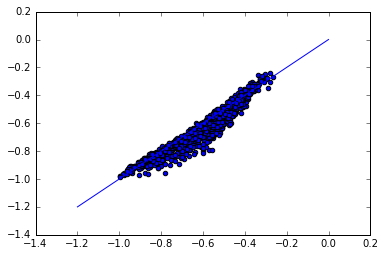

In [104]:
# diff estimation
# cutを大きくすれば、誤差を生んでるところを消せるので精度が上がる
df["diff_est"] = logreg.predict_proba(X)[:, 0] - logreg.predict_proba(X)[:, 2]
d = df["diff"].values
d_est = df["diff_est"].values
plt.scatter(d, d_est)
a = np.linspace(-1.2, 0,200)
plt.plot(a, a)
plt.savefig("logit.png")
plt.show()

In [105]:
# 推定値を用いてRobust推定
pop = df[["Pop"]].values[:, 0]
dist1 = df[["Dist1"]].values[:, 0]
dist2 = df[["Dist2"]].values[:, 0]
num0 = df[["num0"]].values[:, 0]
num2 = df[["num2"]].values[:, 0]
diff = df[["diff_est"]].values[:, 0]
initial = [0.8,-0.5,-0.25]
tole = 0.000005
maxx = 100000
result_rob2 = NR(initial, robust, tole, maxx)

NR終わり


In [106]:
# cutを大きくすればバイアスは消せる。（そういう仮定を置くということ）
result_rob2

array([ 0.80851591, -0.50332032, -0.19265647])

### br

In [107]:
# make dummy variable
df["realized_entry"] = df["realized_entry"].apply(str)
dummy_df = pd.get_dummies(df[["realized_entry"]])
df = pd.merge(df, dummy_df, left_index=True, right_index=True)

In [108]:
entry0 = df[["realized_entry_0"]].values[:, 0]
entry1 = df[["realized_entry_1"]].values[:, 0]
entry2 = df[["realized_entry_2"]].values[:, 0]

def brM(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = entry0*(np.log(s.cdf(-xb1)*s.cdf(-xb2))) \
    + entry2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + entry1*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return sum(logl)

def brM1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = entry0*(np.log(s.cdf(-xb1)*s.cdf(-xb2))) \
    + entry2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + entry1*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return logl

In [109]:
result_brM = NR(initial, brM, tole, maxx)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarni

NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))


In [110]:
result_brM

array([ 0.6965522 , -0.42540351, -0.0150792 ])

In [113]:
def hausmanM(result1, result2):
    # ここ違くない？
    # サンプルの一つずつに対してヘッセを計算して、足し合わせるんでしょ？
    H_br = nd.Hessian(brM)(result1)
    inv_H_br = inv(H_br)
    tri_1 = -inv_H_br

    J_br = nd.Jacobian(brM1)(result1)
    circle_1 = np.dot(J_br.T, J_br)

    G_rob = nd.Gradient(robust)(result2)
    a = np.matrix(G_rob)
    tri_3 = -np.dot(inv(np.dot(a.T, a)), a.T)

    b = np.matrix(robust1(result2)).T
    circle_3 = np.dot(J_br.T, b)

    circle_6 = robust(result2)

    A_11 = np.dot(np.dot(tri_1, circle_1), tri_1.T)
    A_33 = np.dot(np.dot(tri_3, circle_6), tri_3.T)
    A_13 = np.dot(np.dot(tri_1, circle_3), tri_3.T)
    A_31 = np.dot(np.dot(tri_3, circle_3.T), tri_1.T)
    
    avar = A_11 - A_13 -A_31 + A_33
    gap = np.matrix(result1 - result2)
    h = np.dot(np.dot(gap, inv(avar)), gap.T)
    
    return h, np.rank(avar)

In [114]:
hausmanM(result_brM, result_rob2)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarni

(matrix([[-13591.21281722]]), 2)